<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/05-Time_Series/C-ERCOT_using_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing electricity usage from Electric Reliability Council of Texas (ERCOT)

ERCOT releases the electricity usage of their grid at http://www.ercot.com/gridinfo/load

The archives are at: http://www.ercot.com/gridinfo/load/load_hist

ERCOT also publishes their own load forecasts, this is a good baseline for any model.

In [ ]:
!pip install -U -q pip
!pip install -U -q statsmodels xlrd PyMySQL sqlalchemy sql_magic prophet

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sqlalchemy import create_engine

matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

# Load and plot the data


In [3]:
conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org', 
    user = 'student',
    password = 'dwdstudent2015', 
    db = 'ercot',
    encoding = 'utf8mb4')

engine = create_engine(conn_string)
con = engine.connect()

# This query loads the dataset from the DB into the dataframe 
df = pd.read_sql("SELECT * FROM ercot.electricity", con=con)
df = df.set_index('DATE_TIME')

con.close()

In [4]:

df

COAST         EAST        FWEST       NORTH  \
DATE_TIME                                                                 
2002-01-01 01:00:00   8331.469266  1111.096549  1094.045496  995.298392   
2002-01-01 02:00:00   8107.805431  1091.481584  1083.517981  981.195477   
2002-01-01 03:00:00   7890.721717  1080.257616  1085.038740  971.305257   
2002-01-01 04:00:00   7799.817527  1079.726403  1093.381853  971.262963   
2002-01-01 05:00:00   7815.968171  1087.934961  1106.651296  982.535591   
...                           ...          ...          ...         ...   
2021-12-31 20:00:00  13926.775034  1566.583851  4192.977787  916.124441   
2021-12-31 21:00:00  13498.908542  1549.687559  4149.062209  886.943872   
2021-12-31 22:00:00  13116.012129  1515.852644  4148.330779  859.408149   
2021-12-31 23:00:00  12754.392799  1457.080439  4161.355505  831.148872   
2022-01-01 00:00:00  12386.413060  1415.239264  4119.738722  807.084492   

                            NCENT        SOUTH        SCENT         WEST  \
DATE_TIME                                                                  
2002-01-01 01:00:00  10336.304899  2165.007571  4793.193560   843.747177   
2002-01-01 02:00:00  10178.052738  2092.374118  4766.918187   835.488188   
2002-01-01 03:00:00  10100.887710  2042.080714  4702.918892   830.694878   
2002-01-01 04:00:00  10081.565109  2011.935791  4669.064391   835.068413   
2002-01-01 05:00:00  10192.218670  2002.487678  4695.011904   848.598209   
...                           ...          ...          ...          ...   
2021-12-31 20:00:00  11942.416165  3910.031058  7401.098687  1133.093917   
2021-12-31 21:00:00  11406.911057  3681.222926  7088.478765  1102.727285   
2021-12-31 22:00:00  10978.547227  3515.077507  6800.707246  1071.686005   
2021-12-31 23:00:00  10578.729201  3368.125857  6497.990404  1049.414195   
2022-01-01 00:00:00  10140.379573  3234.113244  6151.440423  1016.183096   

                            ERCOT  
DATE_TIME                          
2002-01-01 01:00:00  29670.162911  
2002-01-01 02:00:00  29136.833703  
2002-01-01 03:00:00  28703.905525  
2002-01-01 04:00:00  28541.822450  
2002-01-01 05:00:00  28731.406478  
...                           ...  
2021-12-31 20:00:00  44989.100940  
2021-12-31 21:00:00  43363.942215  
2021-12-31 22:00:00  42005.621687  
2021-12-31 23:00:00  40698.237272  
2022-01-01 00:00:00  39270.591873  

[175320 rows x 9 columns]

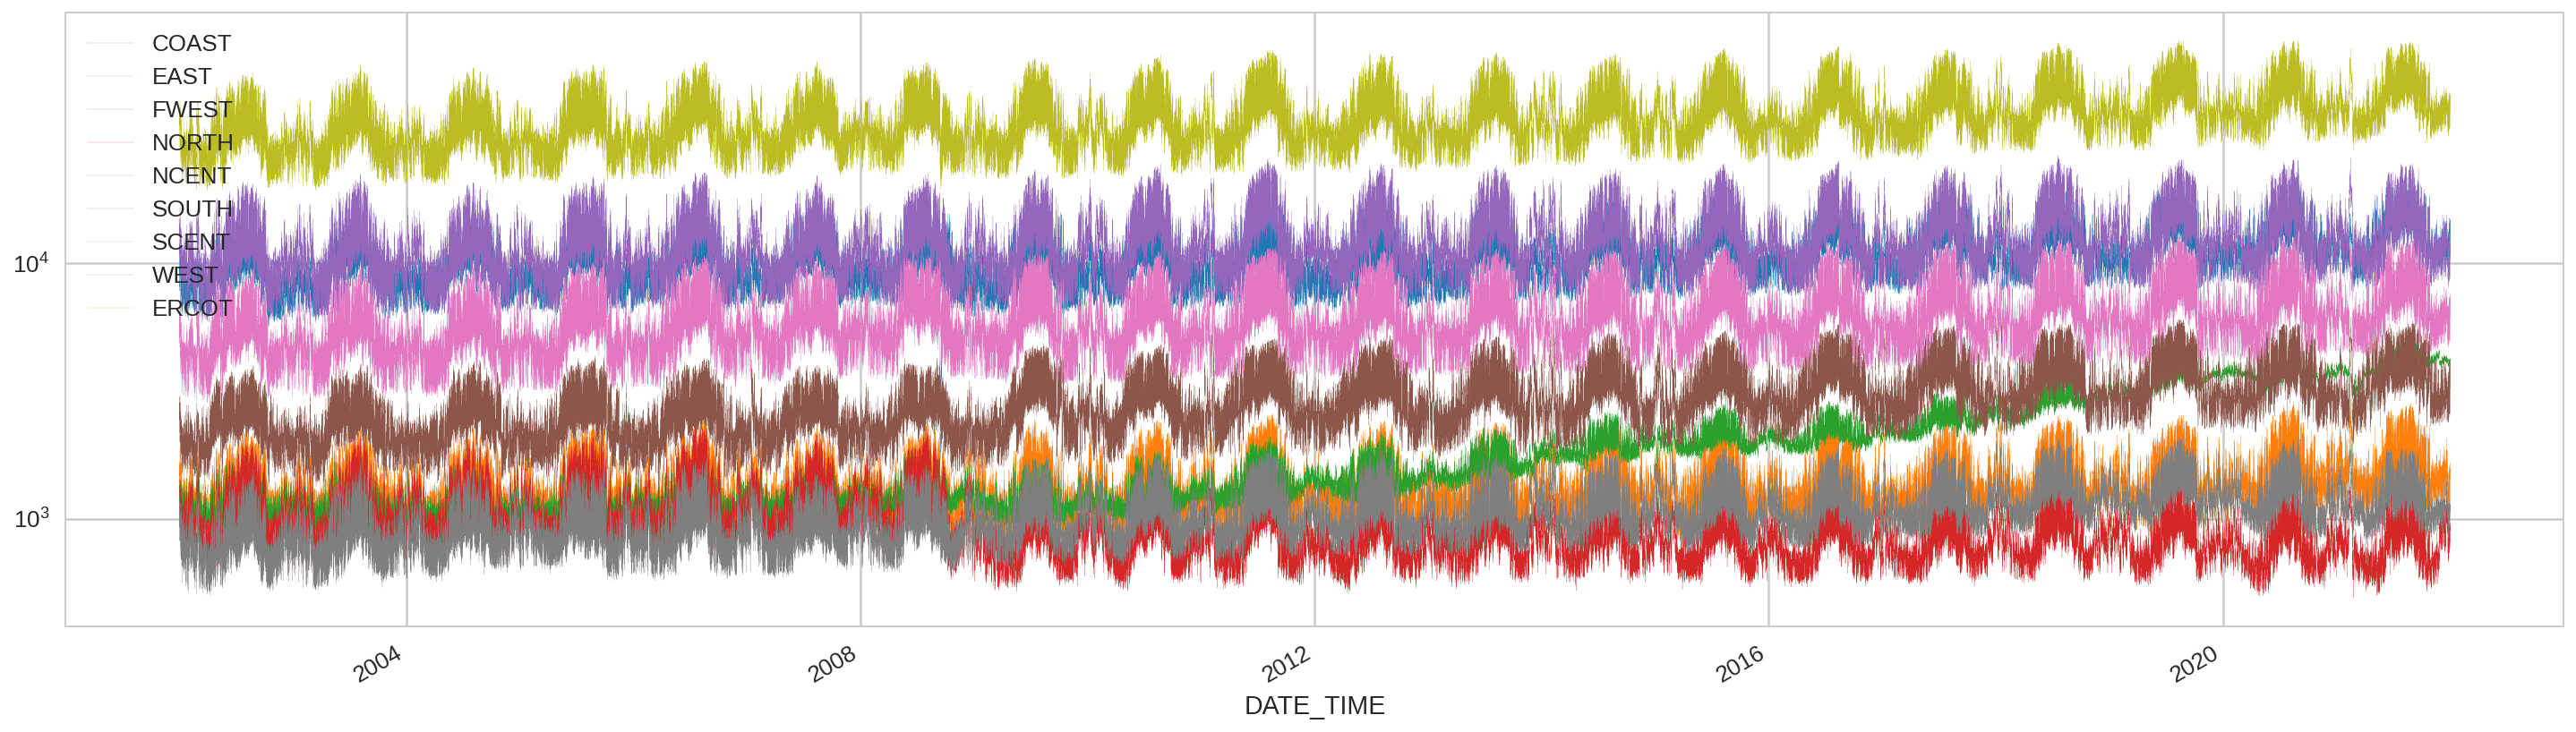

In [5]:
df.plot(figsize=(25,7), linewidth=0.1, logy=True)

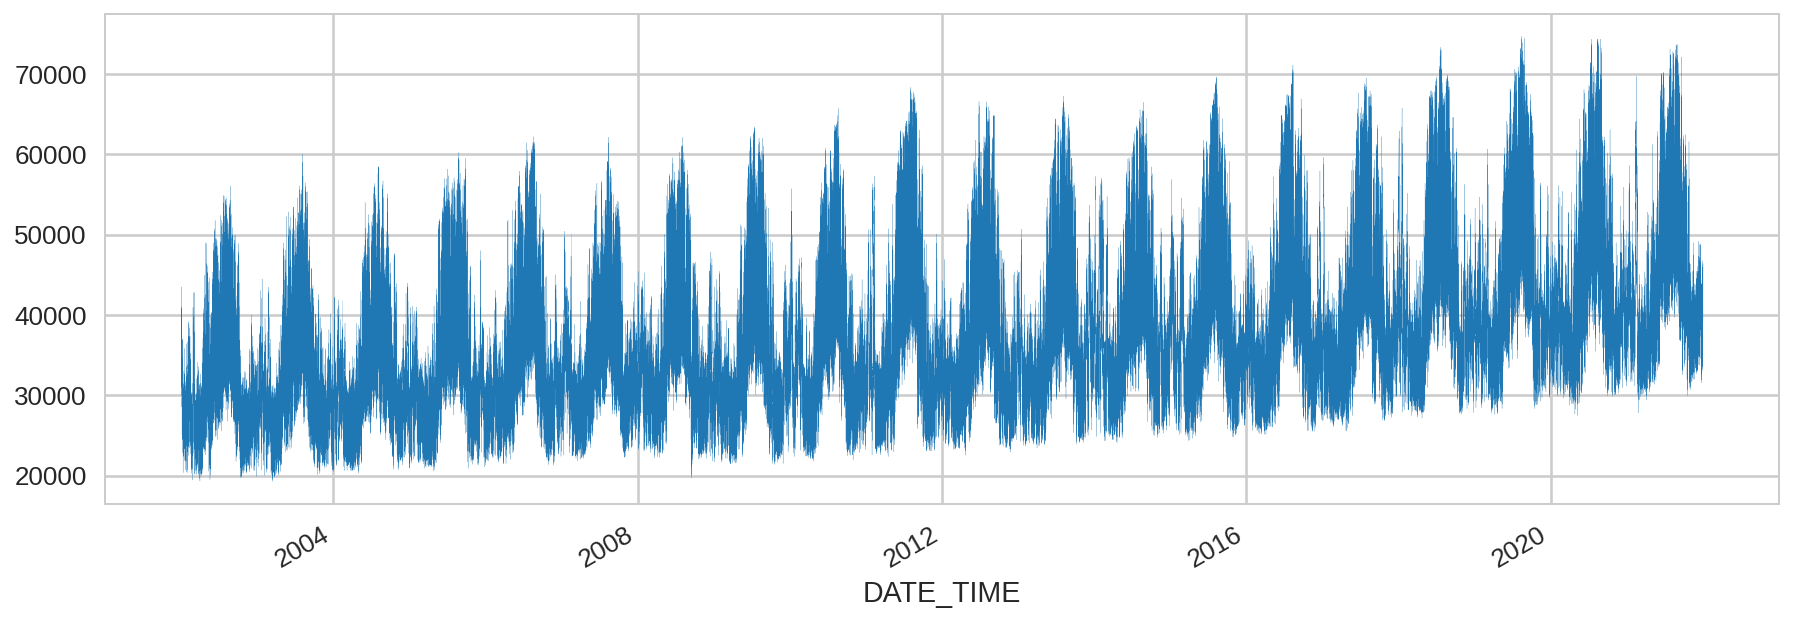

In [6]:
df.ERCOT.plot(linewidth=0.1, figsize=(15,5))


## Analyzing the time series using Prophet

In [7]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [8]:
# We can remove the resampling part and use hourly data
# but it takes ~10 mins on Colab to process the time series
# with hourly data. The tradeoff of working with daily data
# is that we do not extract the seasonality component within
# the day.

edf = (
    df
    .resample('1D').sum() # we will work with daily data
    .reset_index()
    .filter( items = ['DATE_TIME', 'ERCOT'])
    .rename( {'DATE_TIME': 'ds', 'ERCOT': 'y'}, axis="columns" )
)
edf


ds              y
0    2002-01-01  729094.619969
1    2002-01-02  858685.138855
2    2002-01-03  887038.727758
3    2002-01-04  835805.917203
4    2002-01-05  688178.219393
...         ...            ...
7301 2021-12-28  976097.433802
7302 2021-12-29  974899.953573
7303 2021-12-30  961577.567012
7304 2021-12-31  967760.585184
7305 2022-01-01   39270.591873

[7306 rows x 2 columns]

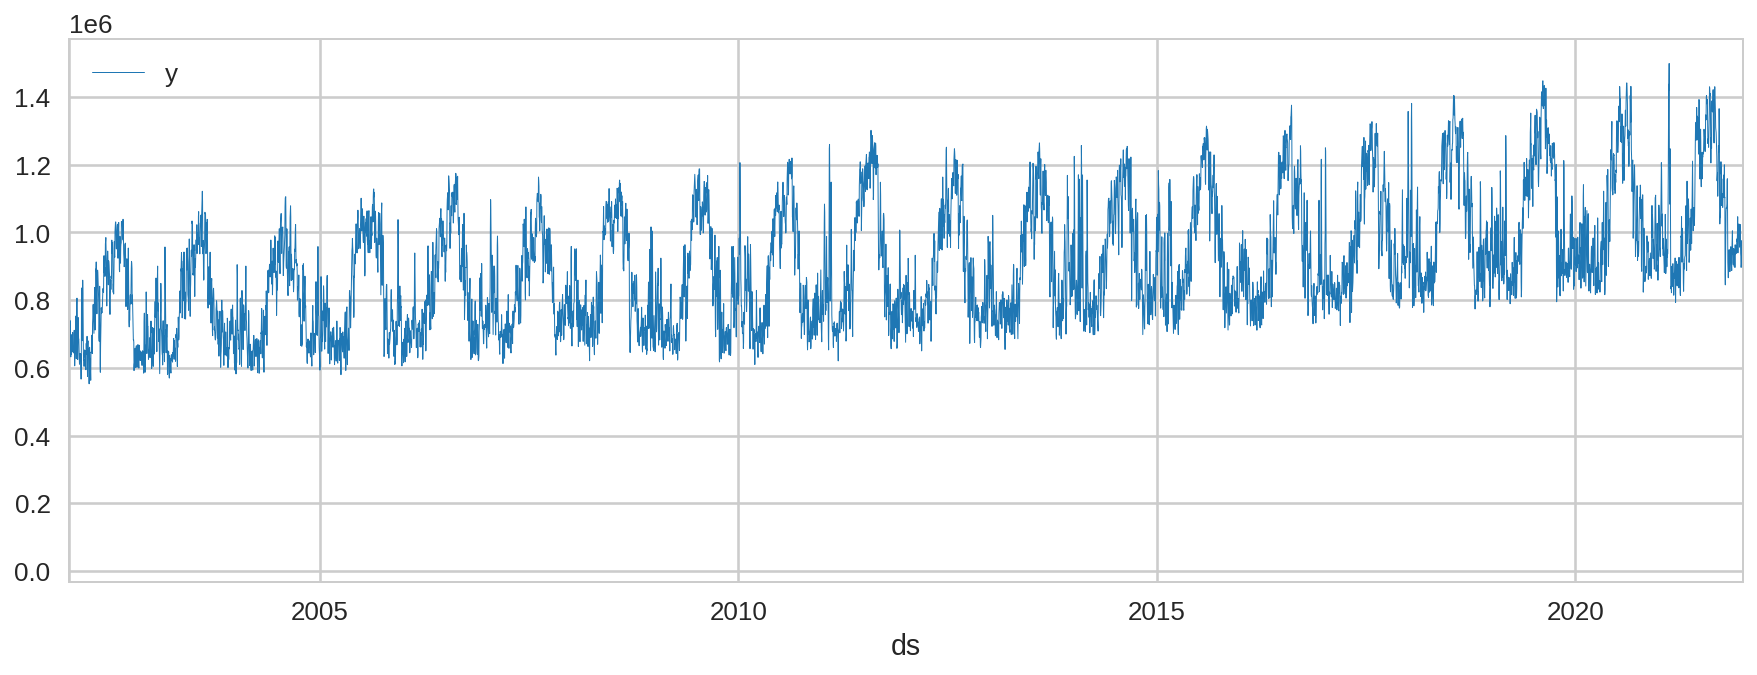

In [19]:
# Plot the daily usage:
edf.set_index('ds').plot(linewidth=0.5, figsize=(15,5))

In [9]:
m = Prophet(seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')
m.fit(edf)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
# future = m.make_future_dataframe(periods=365 * 24, freq='H')
future = m.make_future_dataframe(periods=365)
future.tail()

ds
7666 2022-12-28
7667 2022-12-29
7668 2022-12-30
7669 2022-12-31
7670 2023-01-01

In [11]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds          yhat     yhat_lower    yhat_upper
7666 2022-12-28  1.035639e+06  937172.832385  1.136668e+06
7667 2022-12-29  1.037137e+06  945737.044551  1.130957e+06
7668 2022-12-30  1.028163e+06  931439.728841  1.131326e+06
7669 2022-12-31  9.760098e+05  874962.121668  1.082878e+06
7670 2023-01-01  8.709017e+05  773259.719681  9.714830e+05

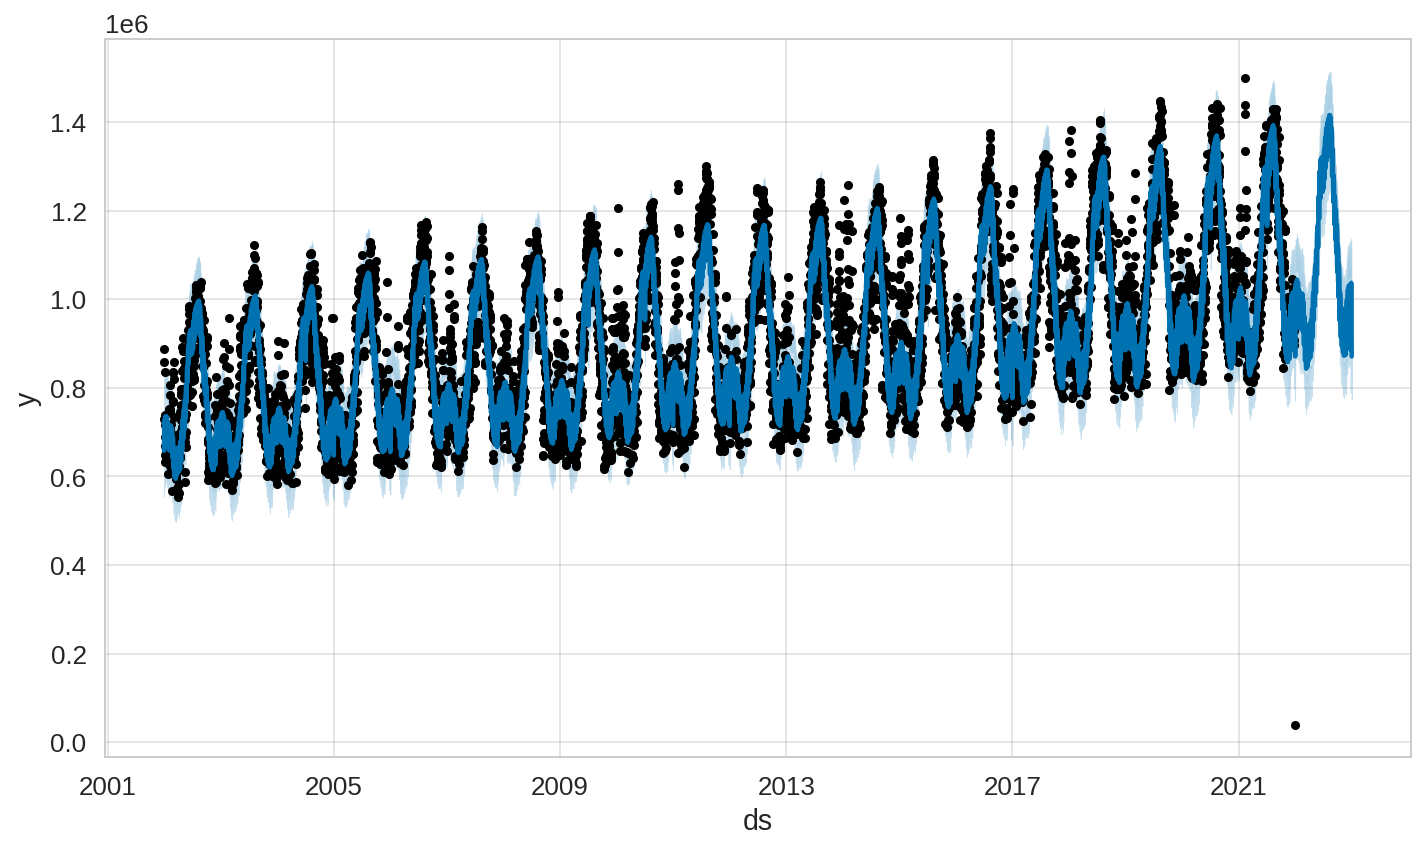

In [12]:
fig1 = m.plot(forecast)

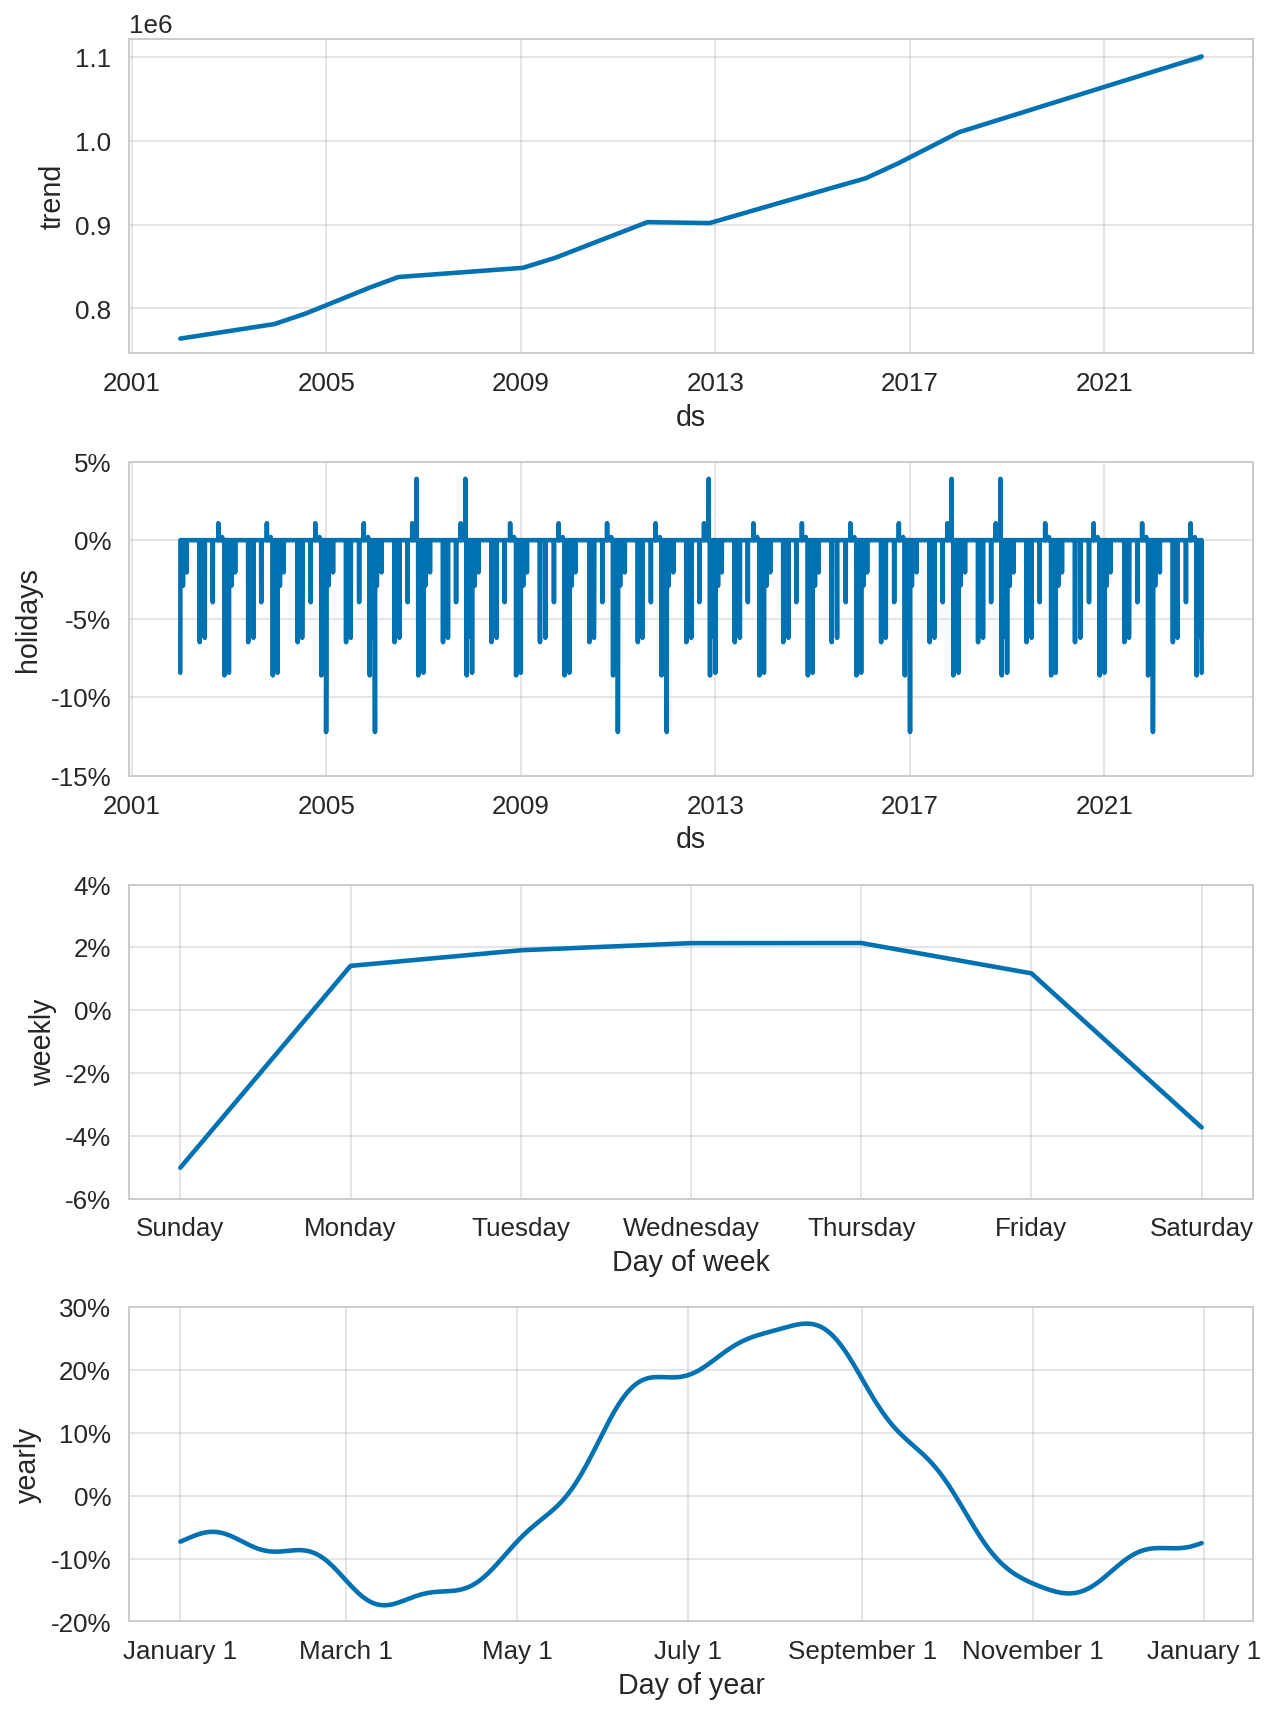

In [13]:
fig2 = m.plot_components(forecast)


In [14]:
plot_plotly(m, forecast)


In [ ]:
plot_components_plotly(m, forecast)